In [1]:
# %% [markdown]
# # CNN Classification using MobileNetV2 on MRI Dataset

# %%
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [6]:

# %% [markdown]
# ## Setup Paths

# %%
# Define dataset and output directories
data_dir = Path(r"C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\MRI_DATA")
output_dir = Path(r"C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\cnn_direct_training_output")
os.makedirs(output_dir, exist_ok=True)

model_path = output_dir / "mobilenetv2_mri_pd_classifier.keras"


In [3]:

# %% [markdown]
# ## Dataset Overview
# Expected folder structure:
# ```
# MRI_DATA/
# ├── PD Patients/
# │   ├── patient_001/
# │   │   ├── ...images...
# │   └── ...
# └── Non PD Patients/
#     ├── patient_002/
#     │   ├── ...images...
#     └── ...
# ```

# %%
# Create ImageDataGenerators for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,         # 20% validation split
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# %% [markdown]
# ## Load Pretrained CNN (MobileNetV2)

# %%
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


Found 35206 images belonging to 2 classes.
Found 8801 images belonging to 2 classes.


In [4]:

# Freeze base layers to use pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Build final classification model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# %% [markdown]
# ## Train the Model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:

# %%
# Define callbacks
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

# %% [markdown]
# ## Training Curves


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7328 - loss: 0.5670

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.74332, saving model to C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\cnn_direct_training_output\mobilenetv2_mri_pd_classifier.keras
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 877s 396ms/step - accuracy: 0.7328 - loss: 0.5670 - val_accuracy: 0.7433 - val_loss: 0.5576
Epoch 2/20
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7876 - loss: 0.4610
Epoch 2: val_accuracy improved from 0.74332 to 0.75128, saving model to C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\cnn_direct_training_output\mobilenetv2_mri_pd_classifier.keras
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 925s 420ms/step - accuracy: 0.7876 - loss: 0.4610 - val_accuracy: 0.7513 - val_loss: 0.5445
Epoch 3/20
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8014 - loss: 0.4299
Epoch 3: val_accuracy did not improve from 0.75128
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 866s 393ms/step - accuracy: 0.8014 - loss: 0.4299 - val_accuracy: 0.7483 - val_loss: 0.5475
Ep

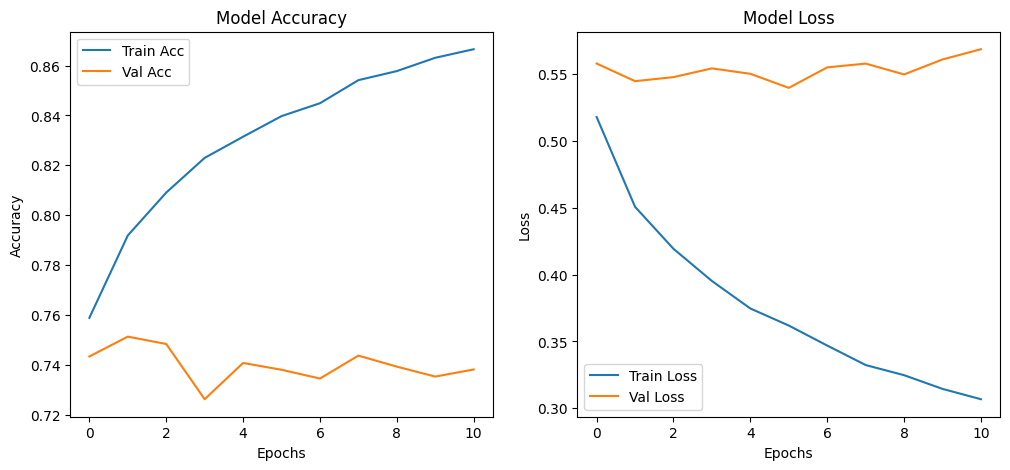

In [8]:

# %%
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# %% [markdown]
# ## Evaluate on Validation Data


In [9]:

# %%
val_loss, val_acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# %% [markdown]
# ## Save Final Model

# %%
model.save(model_path)
print(f"✅ Model saved successfully at: {model_path}")


551/551 ━━━━━━━━━━━━━━━━━━━━ 178s 322ms/step - accuracy: 0.5163 - loss: 0.8134
✅ Validation Accuracy: 0.7398, Validation Loss: 0.5395
✅ Model saved successfully at: C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\cnn_direct_training_output\mobilenetv2_mri_pd_classifier.keras


In [10]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model(r"C:\Users\kowsh\OneDrive\Desktop\ViT\_CAPSTONE_\Parkinson Disease\cnn_direct_training_output\mobilenetv2_mri_pd_classifier.keras")

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)